<a href="https://colab.research.google.com/github/aramis2008/portfolio/blob/master/DCGANCartoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

from google.colab import drive
drive.mount('/content/drive')

Random Seed:  999
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [28]:

workers = 4
# размер батча
batch_size = 64

# размер который будет у генерируемого изображения
image_size = 64

# Число каналов
nc = 3

# размер z latent vector (size of generator input)
nz = 400

# размер feature maps в генераторе
ngf = 64

# размер feature maps в дискриминаторе
ndf = 64

# количество эпох
num_epochs = 25

# Learning rate for optimizers
lr = 0.0023

# Beta1 hyperparam for Adam optimizers
beta1 = 0.3

momentum = 0.3

# ключ для доступа к gpu. для cpu использовать 0.
ngpu = 1

# Root directory for dataset
dataroot = '/content/drive/My Drive/phot/CartoonNetwork/'


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

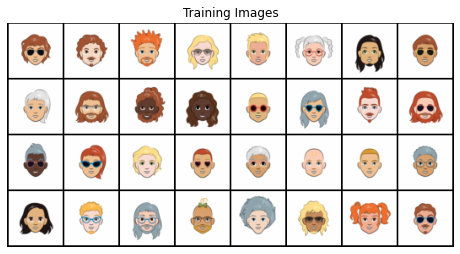

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=True),
            nn.BatchNorm2d(ngf * 8, momentum = momentum),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 4, momentum = momentum),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2, momentum = momentum),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=True),
            nn.BatchNorm2d(ngf, momentum = momentum),
            nn.Dropout3d(p=0.05),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=True),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Dicrimunator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf , momentum = momentum),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, momentum = momentum),
          #  nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(ndf*2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, momentum = momentum),
           # nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8, momentum = momentum),
          #  nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 12, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 12, momentum = momentum),
           # nn.Dropout3d(p=0.05),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 12, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [29]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(400, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (2): Dropout3d(p=0.05, inplace=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (6): Dropout3d(p=0.05, inplace=False)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (10): Dropout3d(p=0.05, inplace=False)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (14): Dropout3d(p=0.05, inplace=False)
    (15): ReLU(inplace=T

In [30]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
#optimizerD = optim.SGD(netD.parameters(), lr=0.008, momentum=0.96)
optimizerD = optim.Adam(netD.parameters(), lr=lr*0.9, betas=(beta1, 0.999))
lr_schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=4, gamma=0.55)
#lr_schedulerD = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizerD, patience=5)
#optimizerG = optim.SGD(netG.parameters(), lr=0.0065, momentum=0.92)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=0.1)
lr_schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=4, gamma=0.55)

## **Train**

In [31]:
# Training Loop

# Lists to keep track of progress
img_list = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        #lr_schedulerD.step(errD)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        #lr_schedulerG.step(errG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        if (iters % 400 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list2.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    lr_schedulerG.step()
    lr_schedulerD.step()

Starting Training Loop...
[0/25][0/136]	Loss_D: 2.4614	Loss_G: 25.9518	D(x): 0.2813	D(G(z)): 0.5081 / 0.0000
[0/25][50/136]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[0/25][100/136]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/25][0/136]	Loss_D: 100.0000	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[1/25][50/136]	Loss_D: 2.7151	Loss_G: 7.7186	D(x): 0.8894	D(G(z)): 0.2729 / 0.0995
[1/25][100/136]	Loss_D: 21.8038	Loss_G: 5.0698	D(x): 0.9717	D(G(z)): 0.4444 / 0.1959
[2/25][0/136]	Loss_D: 12.2861	Loss_G: 2.0098	D(x): 0.8524	D(G(z)): 0.3562 / 0.2634
[2/25][50/136]	Loss_D: 17.2731	Loss_G: 3.7258	D(x): 0.9014	D(G(z)): 0.7342 / 0.1511
[2/25][100/136]	Loss_D: 0.5169	Loss_G: 6.0808	D(x): 0.9739	D(G(z)): 0.2828 / 0.0958
[3/25][0/136]	Loss_D: 0.7204	Loss_G: 3.6384	D(x): 0.8631	D(G(z)): 0.2648 / 0.1031
[3/25][50/136]	Loss_D: 2.3030	Loss_G: 2.3134	D(x): 0.6470	D(G(z)): 0.0764 / 0.2016
[3/25][100/136]	Loss_D: 3.1464	Loss_G: 1.1932	D(x): 

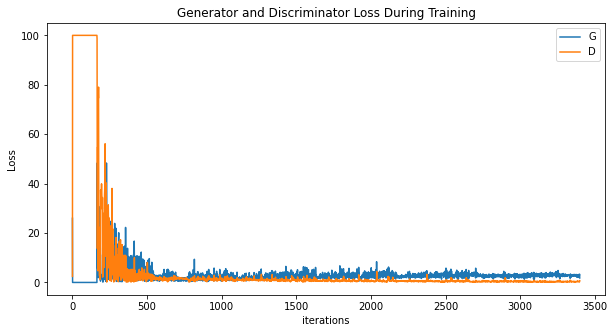

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
print(optimizerG)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.3, 0.999)
    eps: 1e-08
    initial_lr: 0.0023
    lr: 6.366547343750003e-05
    weight_decay: 0.1
)


In [1]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list2]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

NameError: ignored